In [1]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel

from sklearn.preprocessing import LabelEncoder

import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [3]:
dataset = pd.read_csv("../data/train_simple.gzip", compression="gzip")
dataset.shape

In [4]:
cat_cols = ["region", "osm_city_nearest_name", "realty_type"]

for col in cat_cols:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])

In [5]:
dataset["floor"] = dataset["floor"].fillna(1)
dataset["city_population"] = dataset["city_population"].fillna(0)

In [6]:
dataset["price_type"] = dataset["price_type"].astype(bool)

In [7]:
dataset.isna().sum().sum()

0

## **Описание задачи**

Предсказание цены коммерческой недвижимости. Оценка вручную занимает много времени (долгая оценка = задержка решения по выдаче кредита → можно потерять клиента), зато есть много данных по оценке стоимости недвижимости из объявлений в интернете. Предлагается сравнить эти 2 группы наблюдений.

* [Описание данных](https://russianhackers.notion.site/c666cd6d3d8c44adb79d73f69d3ee81a?v=2b1e857b3252422a87cd95cf51225ba0)
* [Описание исходной задачи](https://russianhackers.notion.site/6b142361271a42feb6581759a8c886e0)

### Step 1. Modeling a causal graph

In [8]:
target = "per_square_meter_price"
treatment = "price_type"

In [9]:
feature_columns = [
    'city_population',                  # население города
    'total_square',                     # Общая площадь
    'osm_catering_points_in_0.005',     # Кол-во заведений общепита в радиусе 500 метров, OpenStreetMap
    'region',                           # Регион
    'floor',                            # Этаж
    'realty_type',                      # Тип недвижимости (закодирован)
    'osm_crossing_closest_dist',        # Расстояние до ближайшего пешеходного перехода
    'osm_city_nearest_name',            # Название ближайшего города по OpenStreetMap
    'osm_subway_closest_dist',          # Расстояние до ближайщей станции метро, OpenStreetMap
    'reform_mean_floor_count_1000',     # Средняя этажность домов в радиусе 1 км по истоинчку РеформаЖКХ
    'osm_transport_stop_closest_dist',  # Расстояние до ближайщей остановки общественного транспорта, OpenStreetMap
    'osm_amenity_points_in_0.001',      # Кол-во объектов связанных с удобством в радиусе 100 метров, OpenStreetMap
    'osm_city_nearest_population',      # Население ближайшего города по OpenStreetMap
    'lng',                              # Долгота
    'osm_city_closest_dist',            # Расстояние до центра ближайшего города, OpenStreetMap
    'osm_crossing_points_in_0.005',     # Кол-во пешеходных переходов в радиусе 500 метров, OpenStreetMap
    'floor_type',                       # тип этажа
    'lat',                              # Широта
    'reform_mean_year_building_500',    # Среднее значение года постройки домов в радиусе 500 метров по истоинчку РеформаЖКХ
    'osm_culture_points_in_0.005',      # Кол-во объектов культуры в радиусе 500 метров, OpenStreetMap
    'reform_house_population_500',      # Коэффициент количества проживающих людей в радиусе 500 метров по источнику РеформаЖКХ
]

In [10]:
graph = nx.DiGraph()
graph.add_nodes_from(feature_columns)
graph.add_edges_from([
    ('city_population', 'reform_house_population_500'),
    ('region', 'city_population'),
    ('lat', 'city_population'),
    ('lng', 'city_population'),
    ('lat', 'region'),
    ('lng', 'region'),
    ('floor', 'floor_type'),
    ('realty_type', 'floor'),
    ('realty_type', 'total_square'),
    ('floor', 'total_square'),
])

graph.add_edges_from([("lat", col) for col in feature_columns if (col.startswith("osm") or col.startswith("reform"))])
graph.add_edges_from([("lng", col) for col in feature_columns if (col.startswith("osm") or col.startswith("reform"))])
graph.add_edges_from([(col, target) for col in feature_columns])
graph.add_edges_from([(col, treatment) for col in feature_columns])
graph.add_edge(treatment, target)

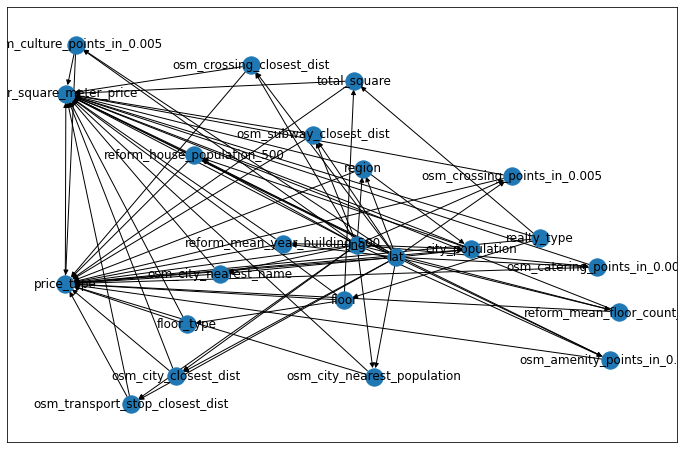

In [11]:
plt.figure(figsize=(12, 8))
nx.draw_networkx(graph, pos=nx.spring_layout(graph))

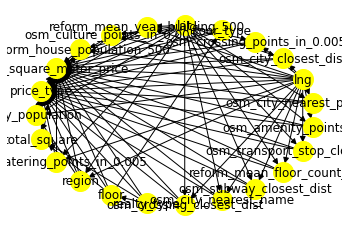

In [12]:
model = CausalModel(
    data=dataset,
    treatment=treatment,
    outcome=target,
    graph=" ".join(nx.generate_gml(graph))
)

model.view_model()

### Step 2. Identification (formulating what to estimate)

In [13]:
%%time

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(per_square_meter_price|reform_mean_floor_count_1000,
d[price_type]                                                                 

                                                                              
osm_catering_points_in_0.005,reform_house_population_500,osm_crossing_points_i
                                                                              

                                                                              
n_0.005,osm_culture_points_in_0.005,region,lat,city_population,total_square,re
                                                                              

                                                                              
form_mean_year_building_500,realty_type,osm_city_nearest_population,floor,floo
                                

### Step 3. Estimation (compute the estimate)

In [14]:
%%time

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification",
    target_units="ate",
)
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(per_square_meter_price|reform_mean_floor_count_1000,
d[price_type]                                                                 

                                                                              
osm_catering_points_in_0.005,reform_house_population_500,osm_crossing_points_i
                                                                              

                                                                              
n_0.005,osm_culture_points_in_0.005,region,lat,city_population,total_square,re
                                                                              

                                                                              
form_mean_year_building_500,realty_type,osm_city_nearest_popula

### Refute

In [15]:
%%time

# Adds randomly drawn covariates to data and re-runs the analysis to see if the 
# causal estimate changes or not. If our assumption was originally correct then 
# the causal estimate shouldn’t change by much.


refute_results = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="random_common_cause",
    random_seed=0
)
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:-11227.910014022353
New effect:-11226.49399135884

CPU times: user 11.3 s, sys: 16.5 s, total: 27.9 s
Wall time: 2.78 s


In [19]:
%%time
#Randomly assigns any covariate as a treatment and re-runs the analysis. If our 
# assumptions were correct then this newly found out estimate should go to 0.

res_placebo = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="placebo_treatment_refuter", 
    placebo_type="permute", 
    num_simulations=5,
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-11227.910014022353
New effect:-720.9695033232153
p value:0.3198797766028214

CPU times: user 44.6 s, sys: 1min, total: 1min 45s
Wall time: 11.4 s


In [17]:
%%time
# What happens to the estimated causal effect when we replace the true outcome 
# variable with an independent random variable? (Hint: The effect should go to zero)

res_dummy = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="dummy_outcome_refuter", 
    placebo_type="permute", 
    num_simulations=5,
)
print(res_dummy[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.008890009343356991
p value:0.2732378476208561

CPU times: user 1min 1s, sys: 1min 14s, total: 2min 15s
Wall time: 13.6 s


In [18]:
%%time
#Creates subsets of the data(similar to cross-validation) and checks whether the 
# causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.

res_subset = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="data_subset_refuter", 
    subset_fraction=0.9, 
    num_simulations=5,
    random_state=0,
)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-11227.910014022353
New effect:-7066.072974813762
p value:0.0

CPU times: user 52.7 s, sys: 1min 4s, total: 1min 57s
Wall time: 11.7 s
